### Name: Kevin O'Farrell
### ID: 0350869

Open a new Jupyter notebook and name it etivity3_classification.ipynb. In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. Then train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`. 

Requirements:

For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
Summarise your experience in a markdown cell (max 150 words in a markdown cell).


In [37]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.svm import SVC
from sklearn.linear_model import RidgeCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
#loop through the column insurance_cost and binarise based on median value
for index, item in df['insurance_cost'].items():
    if item <= df['insurance_cost'].median():
        df.at[index, 'insurance_cost'] = 0
    else:
        df.at[index, 'insurance_cost'] = 1

df.rename(columns={'insurance_cost': 'insurance_cost_binary'}, inplace=True)

In [4]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                    0.0
1   18    male  34.100         0     no  southeast                    0.0
2   18  female  26.315         0     no  northeast                    0.0
3   18  female  38.665         2     no  northeast                    0.0
4   18  female  35.625         0     no  northeast                    0.0

In [5]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost_binary
1333   64  female  31.825         2     no  northeast                    1.0
1334   64  female  26.885         0    yes  northwest                    1.0
1335   64    male  26.410         0     no  northeast                    1.0
1336   64    male  36.960         2    yes  southeast                    1.0
1337   64    male  23.760         0    yes  southeast                    1.0

In [6]:
df.describe()


age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.662182
std      14.049960     6.098187     1.205493               0.473143
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               1.000000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

In [7]:
df.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

No missing values in the data set

In [8]:
#Check the number of values in each class
df['insurance_cost_binary'].value_counts()

1.0    886
0.0    452
Name: insurance_cost_binary, dtype: int64

Because there is equal split, it wont be necessary to stratify the test train split

In [52]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

<Axes: >

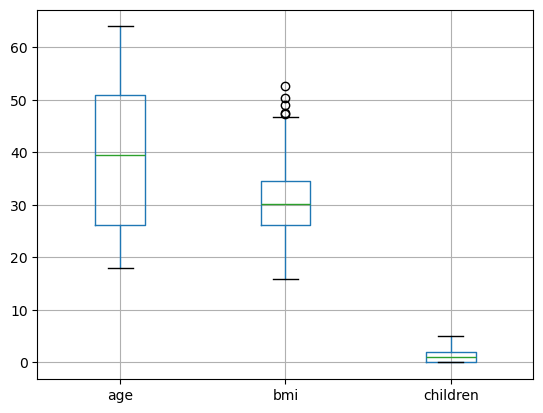

In [11]:
Xtrain.boxplot()

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>, <Axes: >]], dtype=object)

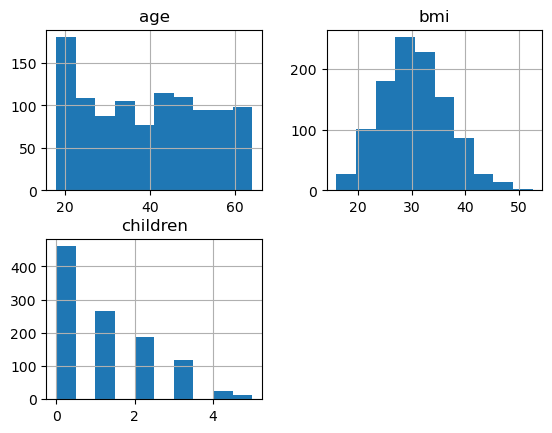

In [12]:
Xtrain.hist()

In [77]:
#group 1
categorical_features = ['gender', 'smoker', 'region']

#group 2
numerical_features = ['age']

#group 3
numerical_features_outliers = ['bmi', 'children']





In [14]:
categorical_pipeline = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

numerical_left_skewed_pipeline = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(np.log)),
        ("scaler", StandardScaler())
    ]
)

numerical_outliers_pipeline = Pipeline(
    steps=[
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipeline, categorical_features),
        ("numerical_left_skewed", numerical_left_skewed_pipeline, numerical_features),
        ("numerical_outliers", numerical_outliers_pipeline, numerical_features_outliers)
    ],
    remainder="passthrough"  # there are no remaining columns
)

In [15]:
#pipeline with SVM and PCA 
pipe_1a = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()), 
    ('svm', SVC(probability=True))
])


In [16]:
#Display the pipeline
set_config(display="diagram")
pipe_1a

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('numerical_left_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi', 'children'])])),
                ('pca', PCA()), ('svm', SVC(probability=True))])

In [17]:


param_grid_1a = {
    'pca__n_components': [2, 4, 6, 8, 10],
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']
     
}

search_1a = GridSearchCV(pipe_1a, param_grid_1a, n_jobs=-1, cv=5, refit=True)
search_1a.fit(Xtrain, ytrain) 

print("Best CV score = %0.3f:" % search_1a.best_score_)
print("Best parameters: ", search_1a.best_params_)

# store the best params and best model for later use
SVM_PCA_best_params = search_1a.best_params_
SVM_PCA_best_model = search_1a.best_estimator_

Best CV score = 0.952:
Best parameters:  {'pca__n_components': 6, 'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [18]:
#pipeline with SVM and RFE 

pipe_1b = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('rfe', RFE(estimator=RandomForestClassifier())),
    ('svm', SVC(probability=True))
])


In [19]:
#Display the pipeline
set_config(display="diagram")
pipe_1b

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('numerical_left_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi', 'children'])])),
                ('rfe', RFE(estimator=RandomForestClassifier())),
                ('svm', SVC(probability=True))])

In [20]:
param_grid_1b = {
    'rfe__n_features_to_select': [2, 4, 6, 8, 10],
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']
     
}

search_1b = GridSearchCV(pipe_1b, param_grid_1b, n_jobs=-1, cv=5, refit=True)
search_1b.fit(Xtrain, ytrain) 

print("Best CV score = %0.3f:" % search_1b.best_score_)
print("Best parameters: ", search_1b.best_params_)

# store the best params and best model for later use
SVM_RFE_best_params = search_1b.best_params_
SVM_RFE_best_model = search_1b.best_estimator_

Best CV score = 0.953:
Best parameters:  {'rfe__n_features_to_select': 4, 'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


In [21]:
#Pipeline Random Forest and PCA
pipe_2a = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()),  
    ('rf', RandomForestClassifier())
])

In [22]:
#Display the pipeline
set_config(display="diagram")
pipe_2a

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('numerical_left_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi', 'children'])])),
                ('pca', PCA()), ('rf', RandomForestClassifier())])

In [23]:
#Select the parameters for gridsearch to use
param_grid_2a = {
    'rf__n_estimators': [10, 20, 30],
    'rf__max_depth': [2, 4, 6, 8],
    'pca__n_components': [2, 4, 6, 8, 10],
}

search_2a = GridSearchCV(pipe_2a, param_grid_2a, n_jobs=-1, cv=5, refit=True)
search_2a.fit(Xtrain, ytrain)
print("Best CV score = %0.3f:" % search_2a.best_score_)
print("Best parameters: ", search_2a.best_params_)

# store the best params and best model for later use
RF_PCA_best_params = search_2a.best_params_
RF_PCA_best_model = search_2a.best_estimator_

Best CV score = 0.953:
Best parameters:  {'pca__n_components': 6, 'rf__max_depth': 8, 'rf__n_estimators': 30}


In [24]:
#Pipeline with Random Forest and RFE
pipe_2b = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('rfe', RFE(estimator=RandomForestClassifier())), 
    ('rf', RandomForestClassifier())
])

In [25]:
#Display the pipeline
set_config(display="diagram")
pipe_2b

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('numerical_left_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi', 'children'])])),
                ('rfe', RFE(estimator=RandomForestClassifier())),
                ('rf', RandomForestClassifier())])

In [36]:

#Select the parameters for gridsearch to use
param_grid_2b = {
    'rf__n_estimators': [10,20, 30, 40],
    'rf__max_depth': [2, 4, 6, 8],
    'rfe__n_features_to_select': [2, 4, 6, 8, 10]
}

search_2b = GridSearchCV(pipe_2b, param_grid_2b, n_jobs=-1, cv=5, refit=True)
search_2b.fit(Xtrain, ytrain)
print("Best CV score = %0.3f:" % search_2b.best_score_)
print("Best parameters: ", search_2b.best_params_)

# store the best params and best model for later use
RF_RFE_best_params = search_2b.best_params_
RF_RFE_best_model = search_2b.best_estimator_

Best CV score = 0.959:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 40, 'rfe__n_features_to_select': 10}


In [27]:
#Pipeline MLPClassifier and select model 
pipe_3 = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('select_model', SelectFromModel(estimator=RandomForestClassifier())),
    ('mlp', MLPClassifier())
])

In [28]:
#Display the pipeline
set_config(display="diagram")
pipe_3

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region']),
                                                 ('numerical_left_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi', 'children'])])),
                ('select_model',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('mlp', MLPClassifier())])

In [29]:
#Set the parameters to search
param_grid_3 = {
    'select_model__estimator__n_estimators': [50, 80, 100, 150],
    'select_model__threshold': ['mean', 'median', '1.5*mean'],
    'mlp__hidden_layer_sizes': [(64,), (128, 64), (256, 128, 64)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}
search_3 = GridSearchCV(pipe_3, param_grid_3, n_jobs=-1, cv=5, refit=True)
search_3.fit(Xtrain, ytrain)
print("Best CV score = %0.3f:" % search_3.best_score_)
print("Best parameters: ", search_3.best_params_)

# store the best params and best model for later use
MLP_best_params = search_3.best_params_
MLP_best_model = search_3.best_estimator_

Best CV score = 0.960:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (256, 128, 64), 'select_model__estimator__n_estimators': 80, 'select_model__threshold': 'median'}


In [30]:
#set the scale of the mean false positive rate from 0-1
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [31]:
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [32]:
#Call the evaluate model function for all three classifiers and store the returned metrics in new variables

SVM_PCA_accuracy, SVM_PCA_precision, SVM_PCA_recall, SVM_PCA_f1, SVM_PCA_tpr, SVM_PCA_auc = evaluate_model(Xtest, ytest, SVM_PCA_best_model)
SVM_RFE_accuracy, SVM_RFE_precision, SVM_RFE_recall, SVM_RFE_f1, SVM_RFE_tpr, SVM_RFE_auc = evaluate_model(Xtest, ytest, SVM_RFE_best_model)
RF_PCA_accuracy, RF_PCA_precision, RF_PCA_recall, RF_PCA_f1, RF_PCA_tpr, RF_PCA_auc = evaluate_model(Xtest, ytest, RF_PCA_best_model)
RF_RFE_accuracy, RF_RFE_precision, RF_RFE_recall, RF_RFE_f1, RF_RFE_tpr, RF_RFE_auc = evaluate_model(Xtest, ytest, RF_RFE_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1, MLP_tpr, MLP_auc = evaluate_model(Xtest, ytest, MLP_best_model)

In [93]:
print("SVM_PCA_accuracy: ", SVM_PCA_accuracy,"SVM_PCA_precision: ", SVM_PCA_precision, "SVM_PCA_recall: ", SVM_PCA_recall,"SVM_PCA_f1: ", SVM_PCA_f1)
print("SVM_RFE_accuracy: ", SVM_RFE_accuracy, "SVM_RFE_precision: ", SVM_RFE_precision,"SVM_RFE_recall: ", SVM_RFE_recall, "SVM_RFE_f1: ", SVM_RFE_f1)
print("RF_PCA_accuracy: ", RF_PCA_accuracy,"RF_PCA_precision: ", RF_PCA_precision,"RF_PCA_recall: ", RF_PCA_recall,"RF_PCA_f1: ", RF_PCA_f1)
print("RF_RFE_accuracy: ", RF_RFE_accuracy,"RF_RFE_precision: ", RF_RFE_precision,"RF_RFE_recall: ", RF_RFE_recall,"RF_RFE_f1: ", RF_RFE_f1)
print("MLP_accuracy: ", MLP_accuracy,"MLP_precision: ", MLP_precision,"MLP_recall: ", MLP_recall,"MLP_f1: ", MLP_f1)

SVM_PCA_accuracy:  0.9253731343283582 SVM_PCA_precision:  0.953757225433526 SVM_PCA_recall:  0.9322033898305084 SVM_PCA_f1:  0.9428571428571428
SVM_RFE_accuracy:  0.9328358208955224 SVM_RFE_precision:  0.9704142011834319 SVM_RFE_recall:  0.9265536723163842 SVM_RFE_f1:  0.9479768786127167
RF_PCA_accuracy:  0.9328358208955224 RF_PCA_precision:  0.9704142011834319 RF_PCA_recall:  0.9265536723163842 RF_PCA_f1:  0.9479768786127167
RF_RFE_accuracy:  0.9402985074626866 RF_RFE_precision:  0.9878787878787879 RF_RFE_recall:  0.9209039548022598 RF_RFE_f1:  0.9532163742690057
MLP_accuracy:  0.9402985074626866 MLP_precision:  0.9820359281437125 MLP_recall:  0.9265536723163842 MLP_f1:  0.9534883720930232


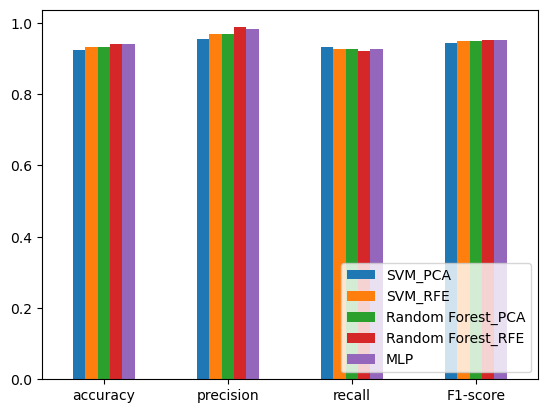

In [33]:
#Plot the metrics of accuracy, precision and recall for three classifiers
SVM_PCA_metrics = np.array([SVM_PCA_accuracy, SVM_PCA_precision, SVM_PCA_recall, SVM_PCA_f1])
SVM_RFE_metrics = np.array([SVM_RFE_accuracy, SVM_RFE_precision, SVM_RFE_recall, SVM_RFE_f1])

RF_PCA_metrics = np.array([RF_PCA_accuracy, RF_PCA_precision, RF_PCA_recall, RF_PCA_f1])
RF_RFE_metrics = np.array([RF_RFE_accuracy, RF_RFE_precision, RF_RFE_recall, RF_RFE_f1])

MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM_PCA': SVM_PCA_metrics, 'SVM_RFE': SVM_RFE_metrics,'Random Forest_PCA': RF_PCA_metrics, 'Random Forest_RFE': RF_RFE_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

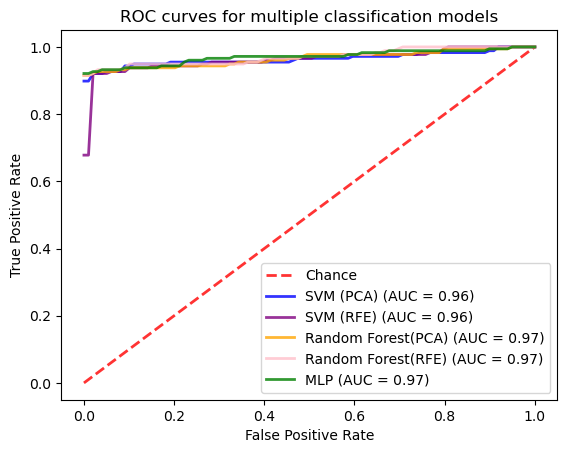

In [34]:
#Plot the three ROC curves using the same colors as the metrics plot

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_PCA_tpr[0,:], lw=2, color='blue', label='SVM (PCA) (AUC = %0.2f)' % (SVM_PCA_auc), alpha=0.8)
plt.plot(mean_fpr, SVM_RFE_tpr[0,:], lw=2, color='purple', label='SVM (RFE) (AUC = %0.2f)' % (SVM_PCA_auc), alpha=0.8)
plt.plot(mean_fpr, RF_PCA_tpr[0,:], lw=2, color='orange', label='Random Forest(PCA) (AUC = %0.2f)' % (RF_PCA_auc), alpha=0.8)
plt.plot(mean_fpr, RF_RFE_tpr[0,:], lw=2, color='pink', label='Random Forest(RFE) (AUC = %0.2f)' % (RF_RFE_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()